In [65]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

import calendar
import datetime
import pytz
import re
import string
from collections import Counter

In [45]:
pd.set_option('display.max_colwidth', 200)

df = pd.read_csv("allkim.csv")
df = df.replace('NaN', np.nan)
times = pd.to_datetime(df['date'], utc=True) 
df['date'] = pd.Index(times).tz_convert('US/Pacific')

pacific = pytz.timezone('US/Pacific')
df.head()

,username,date,retweets,favorites,text,geo,mentions,hashtags,id,permalink
0,KimKardashian,2019-07-22 08:53:00-07:00,227,8262,Thank you for sharing! We are restocking the body foundation soon!https://twitter.com/hgmalaihollo/status/1153130433694932993 …,NaN,NaN,NaN,1153332315281477633,https://twitter.com/KimKardashian/status/1153332315281477633
1,KimKardashian,2019-07-22 08:47:00-07:00,79,1413,Restock alert!!!! My @kkwbeauty Body Collection is coming back to http://Kkwbeauty.com on Friday 07.26 at 9am pst pic.twitter.com/YZDQcv1NZo,NaN,@kkwbeauty,NaN,1153330726911131653,https://twitter.com/KimKardashian/status/1153330726911131653
2,KimKardashian,2019-07-22 08:44:00-07:00,108,2308,My @kkwbeauty Loose Shimmer Powders are so smooth and give your skin an intense glow. My powders also help set the Body Foundation. Shop them at http://Kkwbeauty.com pic.twitter.com/GGQnGQ3bkq,NaN,@kkwbeauty,NaN,1153330101997584384,https://twitter.com/KimKardashian/status/1153330101997584384
3,KimKardashian,2019-07-22 08:41:00-07:00,70,1154,Watch Kim Kardashian’s Makeup Artist Mario Dedivanovic Breaks Down Her Makeup Looks | Allure Video | CNEhttps://www.allure.com/video/watch/kim-kardashian-s-makeup-artist-mario-breaks-down-her-make...,NaN,NaN,NaN,1153329257092792320,https://twitter.com/KimKardashian/status/1153329257092792320
4,KimKardashian,2019-07-20 15:15:00-07:00,134,2506,I’m so excited for you guys to try my new @kkwbeauty Sooo Fire Glosses!!! Shop them at http://Kkwbeauty.com pic.twitter.com/IM0Sjh68C2,NaN,@kkwbeauty,NaN,1152703543641382912,https://twitter.com/KimKardashian/status/1152703543641382912


In [81]:
# Let's start cleaning our data by removing stuff

clean = df.copy().drop(columns = ['username', 'retweets', 'favorites', 'geo', 'mentions', 
                                  'hashtags', 'id', 'permalink'])

def cleaner(data):
    
    # adding column to df to which cleaned tweets will be written
    data["cleaned"] = ""
    
    for index, row in data.iterrows():
        tweet = str(row['text'])
        
        # remove RTs and …
        tweet = re.sub("\s*RT\s*@[^:]*:*","",tweet)
        
        # removing @mentions and #-characters (keeping the word/tag itself tho)
        tweet = re.sub("@[A-Za-z0-9]+","",tweet) 
        tweet = re.sub("#","",tweet) 
        
        # removing some typical urls
        tweet = re.sub("(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*","",tweet)
        tweet = re.sub("pic\.twitter\.com\S*\s?","",tweet)
        tweet = re.sub("bit\.ly.*\s?","",tweet)
        tweet = re.sub("instagr\.am.*\s?","",tweet)
        tweet = re.sub("t\.co.*\s?","",tweet) 
        tweet = re.sub("twitter\.com.*\s?","",tweet)
        tweet = re.sub("[\w/\-?=%.]+\.[\(com)/\-?=%.]+", "", tweet) # removes urls without http or www (hopefully lol)
        
        # removing all numbers and also times (i.e. "12 PM PST"), 
        # since Kimberly likes to announce product drops
        tweet = re.sub(r"[0-9]+\s*([AaPp][Mm])?\s*([Pp][Ss][Tt])?\s*", "", tweet)
        tweet = re.sub("\…", "", tweet)
        
        # miss me with that punctuation am I right? lol
        tweet  = "".join([char for char in tweet if char not in string.punctuation]) 
        
        # placing cleaned tweet into 'cleaned' column
        data.at[index, 'cleaned'] = tweet


cleaner(clean)

# removing all rows where only an empty string or NaN remains
clean = clean[(clean['cleaned'] != " ") & (clean['cleaned'] != "")]

In [85]:
# tokenizing & removing stopwords

# stop_words contains a bunch of words that are pretty useless to us 
# and will consequently be filtered out like literal trash, ugh #relatable 
stop_words = stopwords.words('english')
more_noise = ['i’m', "im", "w", "u"]
stop_words.extend(more_noise)


def tokenize(tweet):
    # basically turning each tweet into a list where each word is an indiv item (token)
    tweet = re.split('\s+', tweet)
    return tweet

def remove_stopwords(tweet):
    # first condition removes stopwords, second condition removes empty strings 
    # which for some reason turned up when I tried this the first time around
    tweet = [word for word in tweet if word.lower() not in stop_words and word]
    return tweet


tokenized = [tokenize(tweet) for tweet in clean["cleaned"]]
stopwords_removed = [remove_stopwords(tweet) for tweet in tokenized]

clean["tokenized_nonstop"] = stopwords_removed

In [86]:
ps = nltk.PorterStemmer()
# so stemming basically reverses inflection so only the root of each word remains but this doesn't seem 
# to be doing anything for Kim anyway so I'm just leaving this here for future reference I guess?

def stemming(tweet):
    text = [ps.stem(word) for word in tweet]
    return tweet

stemmed = [stemming(tweet) for tweet in stopwords_removed]
clean["stemmed"] = stemmed

In [87]:
# glancing over that last column it seems like nothing really happened
# let's check if we need to stem Kim's tweets at all:

diff = 0
for index, row in clean.iterrows():
    if clean["tokenized_nonstop"][index] != clean["stemmed"][index]:
        diff+=1
        
diff # 0

# let's drop this column like Brad Pitt dropped Jen Aniston in 2005
clean = clean.drop(columns="stemmed")

In [88]:
# on to lemmatization which is kinda similar to stemming but not totally the same

wn = nltk.WordNetLemmatizer()

def lemmatizer(tweet):
    tweet = [wn.lemmatize(word) for word in tweet]
    return tweet

lemmatized = [lemmatizer(tweet) for tweet in clean["tokenized_nonstop"]]
clean["lemmatized"] = lemmatized

In [89]:
different = 0
for index, row in clean.iterrows():
    if clean["tokenized_nonstop"][index] != clean["lemmatized"][index]:
        different+=1
        
# different 
# = 7239 
# that's fine then isn't it?

# ok, so we're done with the cleaning for now

In [90]:
# let's compare our cleaned data with the original data in terms of numbers 
# by plotting the yearly tweet amount bars side by side

# function for chopping the dataframe up into years
def yearly_dfs(start, end, frame, string="k"):
    '''
    chops dataframe into smaller dataframes based on the year of the tweets.
    start = first year (will be included)
    end = last year (will be included)
    df = df to be chopped up
    str = a letter that goes with the year since ints can't be variable names
    
    '''
    years = np.arange(start, end+1, 1)
    list_names = [f"k{year}" for year in years] 
    frames = []
    for year in years:
        # resetting index so that the individual frames will be easier to work with later
        # old index will be added as a column, so we will still be able to see the og index
        dataframe = frame[frame['date'].dt.year == year].reset_index() 
        frames.append(dataframe)
    return years, list_names, frames


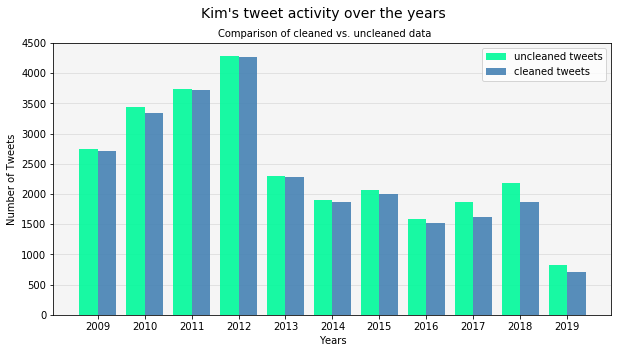

In [91]:
# this is our uncleaned data, the original k
# individual dataframes for each year based on the original dataframe

years, _, frames = yearly_dfs(2009, 2019, frame=df, string="k")

k2009 = frames[0]
k2010 = frames[1]
k2011 = frames[2]
k2012 = frames[3]
k2013 = frames[4]
k2014 = frames[5]
k2015 = frames[6]
k2016 = frames[7]
k2017 = frames[8]
k2018 = frames[9]
k2019 = frames[10]

yearly_tweets = [len(k2009), len(k2010), len(k2011), len(k2012), len(k2013), 
           len(k2014), len(k2015), len(k2016), len(k2017), len(k2018), len(k2019)]


# this is our cleaned data
_, _, c_frames = yearly_dfs(2009, 2019, frame=clean, string="clean")

clean2009 = c_frames[0]
clean2010 = c_frames[1]
clean2011 = c_frames[2]
clean2012 = c_frames[3]
clean2013 = c_frames[4]
clean2014 = c_frames[5]
clean2015 = c_frames[6]
clean2016 = c_frames[7]
clean2017 = c_frames[8]
clean2018 = c_frames[9]
clean2019 = c_frames[10]

cleaned_yearly_tweets = [len(clean2009), len(clean2010), len(clean2011), len(clean2012), len(clean2013), 
           len(clean2014), len(clean2015), len(clean2016), len(clean2017), len(clean2018), len(clean2019)]


# let's plot!
title = "Kim's tweet activity over the years"
n_groups = len(years)
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.9

fig = plt.figure(figsize=(10,5))
fig.suptitle(title, size=14)
ax1 = fig.add_subplot(111)

unclean_bars = ax1.bar(index, yearly_tweets, 
                 bar_width, alpha=opacity, color='mediumspringgreen', label='uncleaned tweets', zorder=2)

clean_bars = ax1.bar(index + bar_width, cleaned_yearly_tweets, 
               bar_width, alpha=opacity, color='steelblue', label='cleaned tweets', zorder=2)

ax1.set_xlabel('Years')
ax1.set_ylabel('Number of Tweets')
ax1.set_title("Comparison of cleaned vs. uncleaned data     ", size=10)
ax1.set_facecolor('whitesmoke')
ax1.grid(axis='y', color='gainsboro', zorder=1)
ax1.legend()

plt.xticks(index + 0.5*bar_width, years, rotation=0)
plt.show()

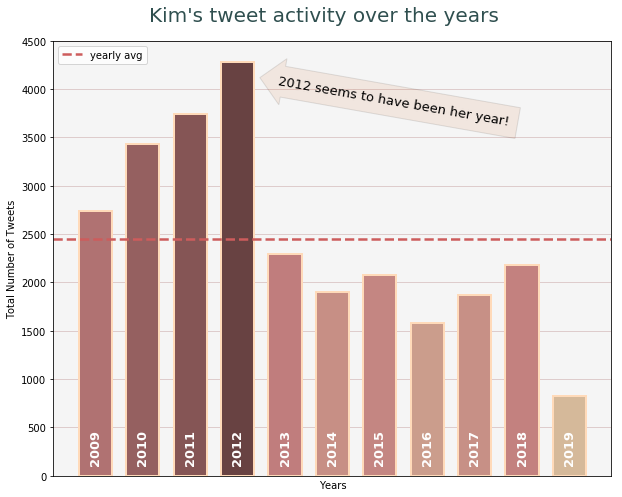

In [96]:
'''
As we can see, there are (as expected) obviously less tweets in our cleaned data 
since some tweets were eliminated in the cleaning process, i.e. tweets that only contained a url or were RTs.
For graphs looking only at numbers it's obviously better to use the original data
since we don't want those tweets to be discarded. They were tweets after all.

Let's make a prettier graph with colors that look like KKW lipsticks lol
'''

# Colorizing the bars based on tweet amount:
scores = np.array(yearly_tweets) # setting scale with which to measure the progression steps on the cmap
data_normalizer = matplotlib.colors.Normalize() # normalizing the data into [0.0, 1.0] interval
colormap = matplotlib.cm.get_cmap('pink_r', 512) # getting a colormap from mlp
newcmp = ListedColormap(colormap(np.linspace(0.45, 0.9, 256))) # reducing the range by slicing the cmap
colors = newcmp(data_normalizer(scores))

fig = plt.figure(figsize=(10,8))
fig.suptitle(title, fontsize=20, color='darkslategrey', y=0.94)

ax = fig.add_subplot(111)
ax.bar(years, yearly_tweets, color=colors, width=.7, zorder=2, ec='peachpuff', linewidth=2, linestyle="-")
ax.set_xlabel("Years")
ax.set_ylabel("Total Number of Tweets")
ax.set_facecolor("whitesmoke")
plt.grid(axis="y", color="rosybrown", alpha=.4, zorder=1, linewidth=1)

# adding a horizontal line for yearly average
mean = np.mean(yearly_tweets)
ax.axhline(mean, c="indianred", label="yearly avg", 
            linewidth=2.5, linestyle="dashed")
ax.legend(loc="upper left")

# annotate
annotaish = "2012 seems to have been her year!"
bbox_props=dict(boxstyle="larrow", pad=0.7, fc="chocolate", alpha=0.1, lw=1)
arrow_props=dict(facecolor='palevioletred', ec='rosybrown', shrink=0.05)
ax.annotate(annotaish, xy=(0.4,0.9), xycoords='axes fraction', rotation=-10,
             size=13, bbox=bbox_props)

# adding the years as text on each bar instead of using x-ticks
ax.set_xticks([])
bars = ax.patches
for index, bar in enumerate(bars):
    (y_bottom, y_top) = ax.get_ylim()
    xloc = years[index]
    yloc = y_bottom + 380
    ax.text(xloc, yloc, str(xloc), color="w", size=13, fontweight="demibold", rotation=90, ha="center")

    
plt.show()

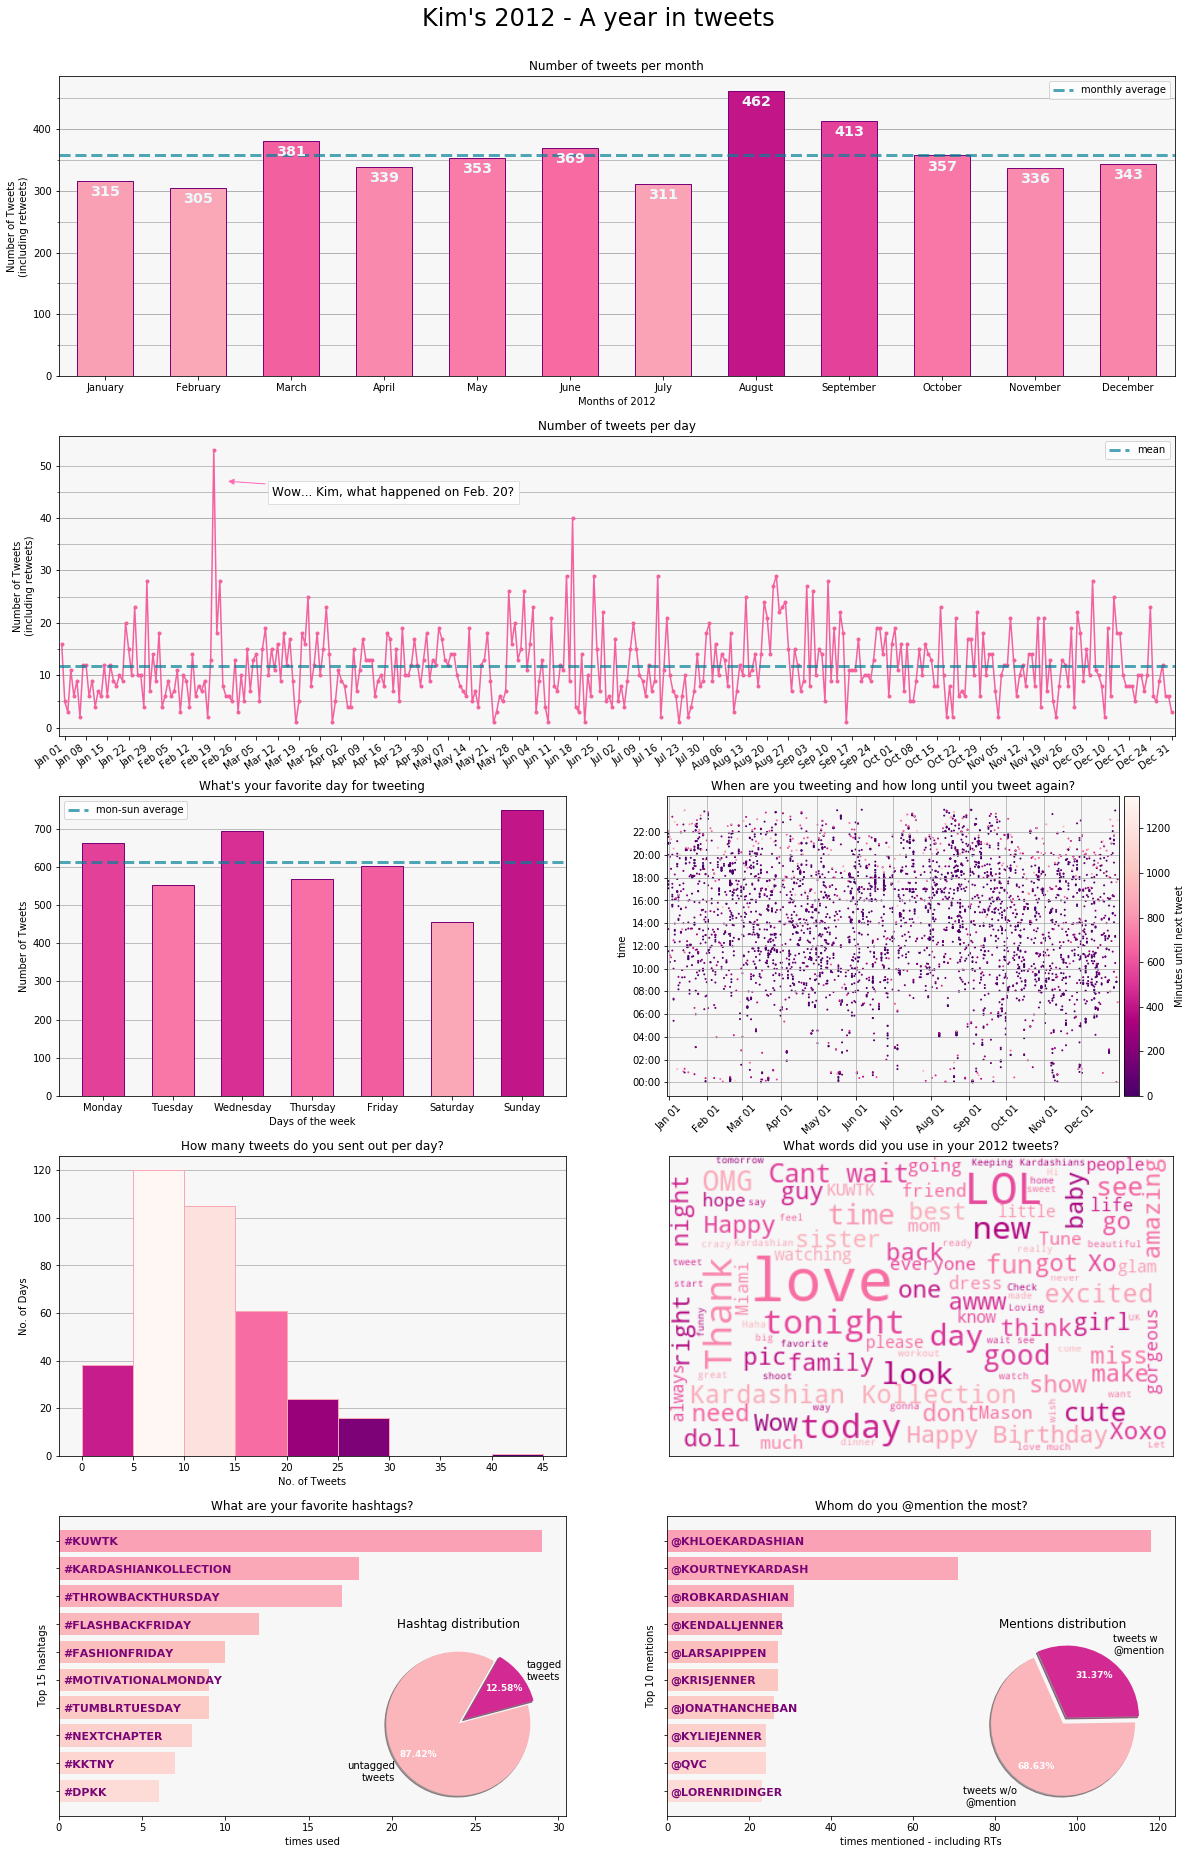

In [209]:
# let's create a bunch of cute looking charts 
# to get a grasp of what 2012 was like for Kimberly on twitter


# this is a function for labeling bars with their y values
def autolabel(rects, ax):
    # rects = ax.patches
    # get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom

    for rect in rects:
        height = rect.get_height()

        # Fraction of axis height taken up by this rectangle
        p_height = (height / y_height)

        # If we can fit the label above the column, do that;
        # otherwise, put it inside the column.
        if p_height > 0.95: # arbitrary; 95% looked good to me.
            label_position = height - (y_height * 0.06)
            
        else:
            label_position = height - (y_height * 0.06)
            # label_position = height + (y_height * 0.01)

        ax.text(rect.get_x() + rect.get_width()/2., label_position,
                '%d' % int(height), color="#edf8fb", fontweight="semibold",
                size="x-large", ha='center', va='bottom')


# function for labeling horizontal bars
def hbar_labeler(ax, bars, label_list, x_offset=0.3):
    for index, bar in enumerate(bars):
        ax.text(bar.get_x()+x_offset, bar.get_y()+0.16, label_list[index], 
                 color="#7A0475", size=11, weight="semibold", stretch="condensed", 
                 ha='left', va='bottom')


# function to pass into plt.pie(autopct=) to label wedges with value+pct
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d} days\n ({p:.2f}%)'.format(p=pct,v=val)
    return my_autopct


title = "Kim's 2012 - A year in tweets"
bg_color = "#f7f7f7"
linecolor = "#078298"
fig = plt.figure(figsize=(20,32))
fig.suptitle(title, size=24, y=0.91)

# adding our axes
ax1 = plt.subplot2grid((5, 2), (0, 0), colspan=2) # monthwise tweet distribution bars
ax2 = plt.subplot2grid((5, 2), (1, 0), colspan=2) # daywise tweet distribution bars
ax3 = plt.subplot2grid((5, 2), (2, 0))            # histogram of daily tweet numbers
ax4 = plt.subplot2grid((5, 2), (2, 1))            # daily tweet hours scatter plot
ax5 = plt.subplot2grid((5, 2), (3, 0))
ax6 = plt.subplot2grid((5, 2), (3, 1))            # weekday distribution bar #6
ax7 = plt.subplot2grid((5, 2), (4, 0))            # hashtags hbars #7
ax7a = fig.add_axes([0.34, 0.115, 0.125, 0.10])   # tiny pie showing pct of hashed vs. unhashed tweets #7a
ax8 = plt.subplot2grid((5, 2), (4, 1))            # mentions hbars 8
ax8a = fig.add_axes([0.76, 0.115, 0.125, 0.10])   # tiny pie showing pct of mention vs. non-mention tweets #8a

for ax in fig.axes:
    ax.set_facecolor(bg_color)
    
ax1.set_title("Number of tweets per month")
ax2.set_title("Number of tweets per day")
ax3.set_title("What's your favorite day for tweeting")
ax4.set_title("When are you tweeting and how long until you tweet again?")
ax5.set_title("How many tweets do you post per day?")
ax6.set_title("What words did you use in your 2012 tweets?")
ax7.set_title("What are your favorite hashtags?")
ax7a.set_title("Hashtag distribution")
ax8.set_title("Who do you @mention the most?")
ax8a.set_title("Mentions distribution")


'''
ax1: bar chart showing Kim's monthly tweet distribution
'''
# data
m = Counter(k2012['date'].sort_values().dt.month)
months = [item for item in m]
month_nums = list(m.values())
monthlabels=list(calendar.month_name)[1:]

# color settings - Colorizing the x bars based on y values:
scores = np.array(month_nums) # setting scale with which to measure the progression steps on the cmap
data_normalizer = matplotlib.colors.Normalize() # normalizing the data into [0.0, 1.0] interval
colormap = matplotlib.cm.get_cmap('RdPu', 512) # getting a colormap from mlp
newcmp = ListedColormap(colormap(np.linspace(0.35, 0.7, 256))) # reducing the range by slicing the cmap
colors = newcmp(data_normalizer(scores))

# graph
ax1.bar(monthlabels, month_nums, width=0.6, zorder=2, color=colors, ec='#7a0177')
ax1.set_xlim((-0.5, 11.5))
ax1.set_xticklabels(monthlabels)
mean = np.mean(month_nums)
ax1.axhline(y=mean, label="monthly average", color=linecolor, linestyle="dashed", linewidth=3, alpha=.7)
ax1.set_yticks(np.arange(0,500,50), minor=True)
ax1.grid(axis='y', zorder=1, which='both')
ax1.legend()
ax1.set_xlabel("Months of 2012")
ax1.set_ylabel("Number of Tweets\n(including retweets)")
rects = ax1.patches 
autolabel(rects, ax1)


'''
ax2 daily tweet distribution
'''
# ax2 data
d = Counter(k2012['date'].sort_values().dt.strftime('%B %d'))
days = [item for item in d]
day_nums = list(d.values()) #[d[item] for item in d]

# ax2 graph
ax2.set_facecolor(bg_color)
ax2.plot(days, day_nums, color='#F3619F', zorder=2, marker=".")
ax2.axhline(y=np.mean(day_nums), label="mean", color=linecolor, linestyle="dashed", linewidth=3, alpha=.7)
ax2.set_xlim((-1, 366))
ax2.xaxis.set_major_locator(mdates.DayLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax2.set_xticks(np.arange(1,366,7))
# setting rotation and alignment of the labels:
for label in ax2.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(35)
ax2.set_yticks(np.arange(0,50,5), minor=True)
ax2.grid(axis='y', zorder=1, which='both')
ax2.legend()
ax2.set_ylabel("Number of Tweets\n(including retweets)")

# ax2 annotation
ax2comment = "Wow... Kim, what happened on Feb. 20?"
bbox_props=dict(boxstyle="square", pad=0.4, fc="w", alpha=.9, ec="gainsboro", lw=1)
arrow_props=dict(arrowstyle="-|>", facecolor='hotpink', ec='hotpink')
ax2.annotate(ax2comment, xy=(0.15,0.85), xytext=(0.3,0.8), xycoords='axes fraction', 
             size=12, color="k", ha="center", arrowprops=arrow_props, bbox=bbox_props)



'''
ax3 weekday tweet distribution
'''
# data
weekdays = list(calendar.day_name)
weekday_tweets_2012 = [] # list with the len of each frame representing the total number of tweets for each weekday
for index in range(len(weekdays)):
    # .dt.weekday returns weekday (0=Monday...) 
    # thus creating a frame for each weekday. we're only storing the length aka total number of tweets
    dayframe = k2012[k2012['date'].dt.weekday == index].reset_index()
    weekday_tweets_2012.append(len(dayframe))


# color settings - Colorizing the x bars based on y values:
ax3_scores = np.array(weekday_tweets_2012) # setting scale with which to measure the progression steps on the cmap
data_normalizer = matplotlib.colors.Normalize() # normalizing the data into [0.0, 1.0] interval
colormap = matplotlib.cm.get_cmap('RdPu', 512) # getting a colormap from mlp
newcmp = ListedColormap(colormap(np.linspace(0.35, 0.7, 256))) # reducing the range by slicing the cmap
ax3colors = newcmp(data_normalizer(ax3_scores))

# chart
ax3.bar(weekdays, weekday_tweets_2012, width=0.6, zorder=2, color=ax3colors, ec='#7a0177')
# ax5.set_xlim((-0.5, 11.5))
ax3.set_xticklabels(weekdays)
mean = np.mean(weekday_tweets_2012)
ax3.axhline(y=mean, label="mon-sun average", color=linecolor, linestyle="dashed", linewidth=3, alpha=.7)
# ax5.set_yticks(np.arange(0,500,50), minor=True)
ax3.grid(axis='y', zorder=1, which='both')
ax3.legend()
ax3.set_xlabel("Days of the week")
ax3.set_ylabel("Number of Tweets")


'''
ax4 scatterplot of times of the day she tweeted over the year
'''
# data for scatter
x_days = k2012['date'].sort_values().dt.date
alltimes = k2012['date'].sort_values().dt.strftime('%H:%M')
y_times = [datetime.datetime.strptime(t, '%H:%M').time() for t in alltimes]
# data for colorbar gradient - figuring out timedelta between tweet and next tweet
timeit = k2012['date'].sort_values().tolist()
minutes = []
for index, time in enumerate(timeit):
    next_index = (index + 1) % len(k2012)
    # when last date in 2012 is reached, first date of 2013 is used to create the delta
    if next_index == 0:
        delta = k2013["date"].sort_values().tolist()[0] - time
    # looking at next time and creating a delta (= how long until the next tweet)
    else:  
        delta = timeit[next_index] - time     
    m = delta.seconds / 60
    minutes.append(int(m))

# settings for colorbar
max_value = max(minutes)
min_value = min(minutes)
ax4_cmap = plt.get_cmap('RdPu_r')
norm = matplotlib.colors.Normalize(vmin=min_value,vmax=max_value)
sm = plt.cm.ScalarMappable(cmap=ax4_cmap, norm=norm)
sm.set_array([])
# adding the colorbar: 
cbar = fig.colorbar(sm, ax=ax4, label="Minutes until next tweet", fraction=0.1, pad=0.01)

# chart
scatter = ax4.scatter(x_days, y_times, s=1, c=minutes, cmap="RdPu_r")
ax4.set_facecolor(bg_color)
ax4.set_xlim([datetime.date(2011, 12, 31), datetime.date(2013, 1, 1)])
firsts = [datetime.date(2012, i, 1) for i in range(1,13)]
ax4.set_xticks(firsts)
y_tick_times = [f"{a:02d}:00:00" for a in range(24) if a%2==0] # list of times for y axis
ax4.set_yticks(y_tick_times)
ax4.set_xticklabels(firsts, rotation=45)
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax4.grid(axis='both', zorder=1, which='both')


''' 
ax5: histogram of the number of tweets she sent out
'''
tweet_amount_bins = np.arange(0,50,5)
hist_cm = plt.cm.get_cmap('RdPu_r')
n, bins, patches = ax5.hist(day_nums, bins=tweet_amount_bins, zorder=2, ec="#FAA7B7")
ax5.set_xlabel("No. of Tweets")
ax5.set_ylabel("No. of Days")
ax5.set_xticks(tweet_amount_bins)
ax5.grid(axis="y", zorder=1)
hist_col = (n-n.min())/(n.max()-n.min())
for color, patch in zip(hist_col, patches):
    plt.setp(patch, 'facecolor', hist_cm(color))


''' ax6 wordcloud for all 2012 tweets'''
# using the cleaned tweets for this
lemmatized_2012_tweets = clean2012['lemmatized'].tolist()
# because each lemmatized tweet is its own list, 
# we need a nested loop to join them all together:
# the first loop loops through the all tweets/lists, 
# the second one loops through each tweet/list individually
tweet_string_2012 = " ".join(word for tweet in lemmatized_2012_tweets for word in tweet)
#tweet_string_2012
wordcloud_cmap = matplotlib.cm.get_cmap('RdPu', 512) # getting a colormap from mlp
new_wc_cmp = ListedColormap(colormap(np.linspace(0.3, 0.8, 256)))


cloudy = WordCloud(height=250, width=420, max_font_size=50, max_words=100, 
                  colormap=new_wc_cmp, background_color=bg_color).generate(tweet_string_2012)
ax6.imshow(cloudy, interpolation='bilinear')
ax6.set_xticks([])
ax6.set_yticks([])

    
'''ax7 hbars of her fav hashtags and
ax7a pie of hashtag vs non-hashtag tweets'''
#data
tagged_tweets_of_2012 = k2012[k2012['hashtags'].notnull()]
hashtag_values_2012 = [tweet.upper() for tweet in tagged_tweets_of_2012['hashtags'].values.tolist()]
hashtag_list_2012 = [] # list of all hashtags she used in 2012
for string in hashtag_values_2012:
    indiv_tags = string.split()
    for i in range(len(indiv_tags)):
        hashtag_list_2012.append(indiv_tags[i])

hashcounter = Counter(hashtag_list_2012)
bar_hashtags = [i[0] for i in hashcounter.most_common(10)][::-1]
bar_hashamounts = [i[1] for i in hashcounter.most_common(10)][::-1]

number_of_hashtagged_tweets_2012 = len(tagged_tweets_of_2012) #539
number_of_untagged_tweets_2012 = len(k2012[k2012['hashtags'].isnull()])

#graph
colors = plt.cm.RdPu(np.linspace(0.15, 0.37, len(bar_hashtags)))
colorspie = plt.cm.RdPu_r(np.linspace(0.35, 0.7, 2))
bars = ax7.barh(bar_hashtags, bar_hashamounts, color=colors)
# calling function from above to label bars
hbar_labeler(ax7, bars, bar_hashtags)
ax7.set_xlabel("times used")
ax7.set_ylabel("Top 15 hashtags")
ax7.set_yticklabels([])
w, text, autotext = ax7a.pie([number_of_hashtagged_tweets_2012, number_of_untagged_tweets_2012], colors=colorspie,
                             startangle=15, explode=[0.1,0], shadow=True, radius=1, labeldistance=1.1,
                             labels=['tagged\ntweets', 'untagged\ntweets'], autopct='%.2f%%', pctdistance=.7)

for at in autotext:
    at.set_color("w")
    at.set_fontweight("bold")
    at.set_fontsize(9)
    


'''ax8 horizontal bar of mentions'''

#data
mentions_of_2012 = k2012[k2012['mentions'].notnull()]
# filtering out retweets to get actual mentions 
no_retweets = mentions_of_2012[mentions_of_2012['text'].str.contains("RT ") == False]
mention_values_2012 = [mention.upper() for mention in no_retweets['mentions'].values.tolist()]
mentions_list_2012 = [] # list of all accts she @mentioned in 2012
for string in mention_values_2012:
    indiv_tags = string.split()
    for i in range(len(indiv_tags)):
        mentions_list_2012.append(indiv_tags[i])

menshcounter = Counter(mentions_list_2012)
bar_mentions = [i[0] for i in menshcounter.most_common(10)][::-1]
bar_mentionamts = [i[1] for i in menshcounter.most_common(10)][::-1]

number_of_mentioned_tweets_2012 = len(no_retweets) 
number_of_unmentioned_tweets_2012 = len(k2012) - number_of_mentioned_tweets_2012

#graph
colorsbar = plt.cm.RdPu(np.linspace(0.15, 0.37, len(bar_mentions)))
colorspie = plt.cm.RdPu_r(np.linspace(0.35, 0.7, 2))
bars = ax8.barh(bar_mentions, bar_mentionamts, color=colorsbar)
# calling function from above to label bars
hbar_labeler(ax8, bars, bar_mentions, x_offset=0.8) 
ax8.set_xlabel("times mentioned - including RTs")
ax8.set_ylabel("Top 10 mentions")
ax8.set_yticklabels([])
w, text, autotext = ax8a.pie([number_of_mentioned_tweets_2012, number_of_unmentioned_tweets_2012], colors=colorspie,
                             startangle=1, explode=[0.1,0], shadow=True, radius=1, labeldistance=1.2,
                             labels=['tweets w\n@mention', 'tweets w/o\n@mention'], autopct='%.2f%%', pctdistance=.7)
for at in autotext:
    at.set_color("w")
    at.set_fontweight("bold")
    at.set_fontsize(9)


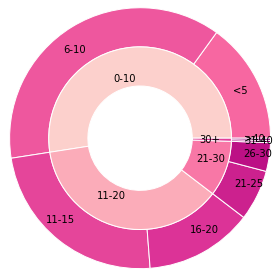

In [98]:
# this is just a test

quantities = np.array([
    [len([a for a in day_nums if a <= 5]), len([a for a in day_nums if 6 <= a <= 10])],
    [len([b for b in day_nums if 11 <= b <= 15]), len([b for b in day_nums if 16 <= b <= 20])],
    [len([c for c in day_nums if 21 <= c <= 25]), len([b for b in day_nums if 26 <= b <= 30])],
    [len([b for b in day_nums if 31 <= b <= 40]), len([d for d in day_nums if d > 40])]
])

explode1 = [0,0,0,0.1]

innerlabels = ["0-10", "11-20", "21-30", "30+"]
outerlabels = ["<5", "6-10","11-15","16-20","21-25","26-30","31-40",">40" ]


fig, ax = plt.subplots()
size = 0.45

cmap = plt.get_cmap("RdPu")
outer_colors = cmap(np.linspace(0.5, 0.8, 2*len(quantities)))
inner_colors = cmap(np.linspace(0.2, 0.6, len(quantities)))

outer = ax.pie(quantities.flatten(), labels=outerlabels, labeldistance=.8, radius=1.5, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

inner = ax.pie(quantities.sum(axis=1), labels=innerlabels, labeldistance=0.65, radius=1.5-size, 
               colors=inner_colors, wedgeprops=dict(width=size, edgecolor='w'))

#ax.set(aspect="equal", title='Pie plot with `ax.pie`')
'''
ax4 pie of daily tweet amount distribution 

# data
quantities = [len([a for a in day_nums if a <= 10]),
             len([b for b in day_nums if 11 <= b <= 20]),
             len([c for c in day_nums if 21 <= c <= 30]),
             len([d for d in day_nums if d > 30])]
explode1 = [0,0,0,0.1]
colors1 = plt.cm.RdPu(np.linspace(0.2, 0.9, len(quantities)))
labels = ["0-10 tweets", "11-20 tweets", "21-30 tweets", "30+ tweets"]


# graph
wedges, texts, autotexts = ax4.pie(quantities, labels=labels, explode=explode1, autopct=make_autopct(quantities),
                                    pctdistance=0.8, shadow=True, startangle=90, counterclock=False, 
                                    wedgeprops=dict(width=0.4), colors=colors1)
    
ax4.legend(title="Daily tweet amounts", loc="lower right", fancybox=True, shadow=True)
for text in texts:
    text.set_alpha(0)
for autotext in autotexts:
    autotext.set_color('w')
    autotext.set_fontweight('demibold')
   
'''



In [99]:
# let's turn to our clean data to look at what she was talking about in 2012
years = np.array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])
tweet_years = [clean2009, clean2010, clean2011, clean2012, clean2013, 
           clean2014, clean2015, clean2016, clean2017, clean2018, clean2019]

# let us join all those tweets together into giant strings almost as long as Kylie's bank statement
clouddict = {}
for index in range(len(tweet_years)):
    key = f"cloud{years[index]}"
    x = tweet_years[index]["lemmatized"].tolist() 
    clouddict[key] = " ".join(word for li in x for word in li)  

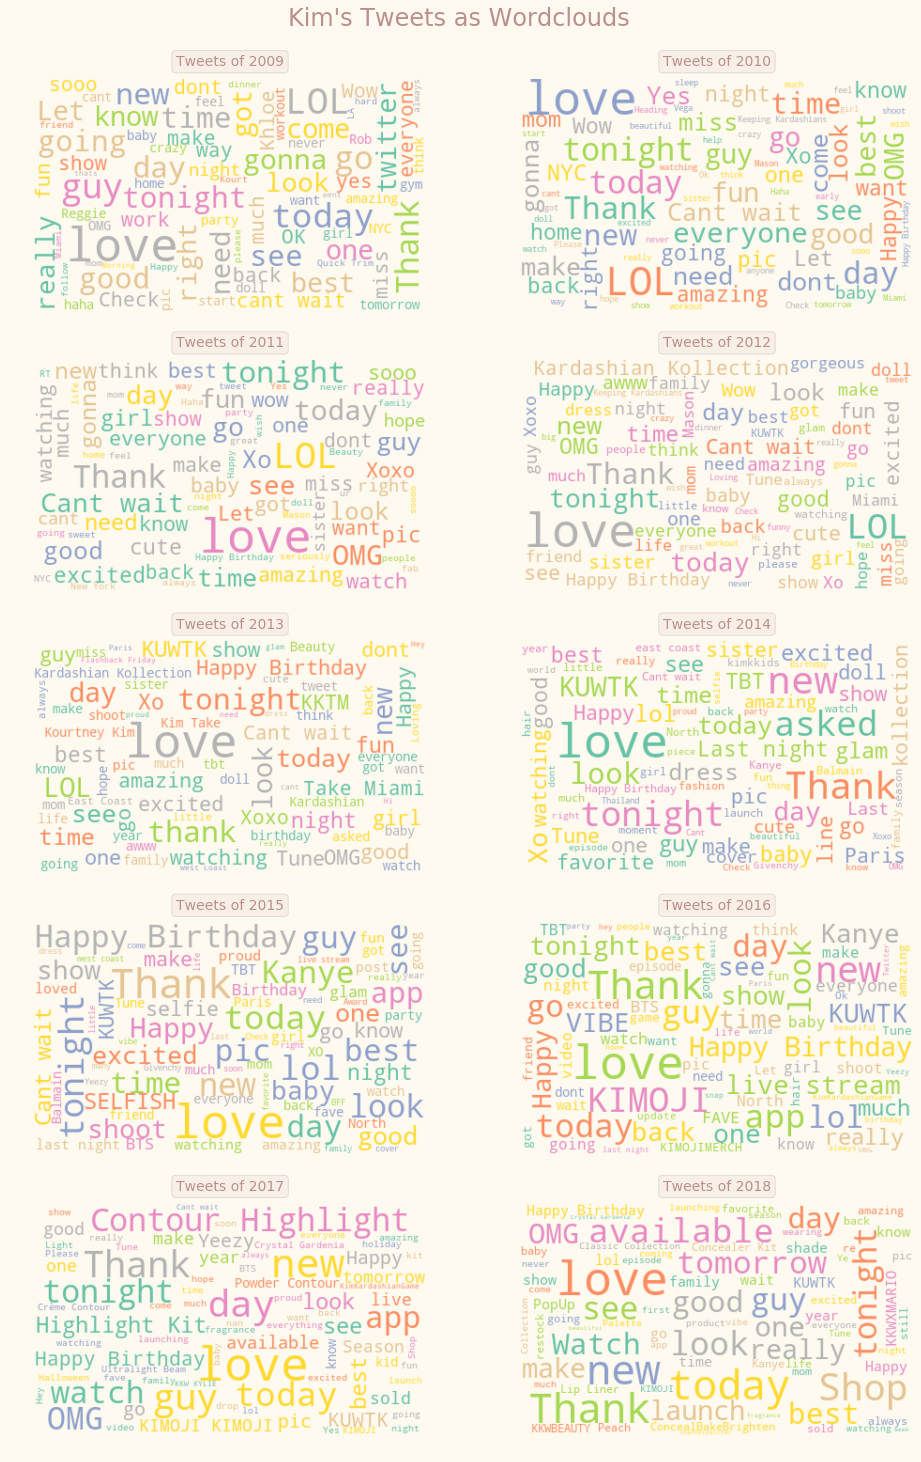

In [59]:
def cloudify(string):
    x = WordCloud(height=250, width=420, max_font_size=50, max_words=80, 
                  colormap="Set2", background_color="floralwhite").generate(string)
    return x

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16,25))
fig.set_facecolor("floralwhite")
fig.suptitle("Kim's Tweets as Wordclouds", size=24, y=0.92, color="rosybrown")

index = 0
for x in range(5):
    for y in range(2):
        cloudy = cloudify(clouddict[f"cloud{years[index]}"])
        ax = axes[x,y]
        ax.imshow(cloudy, interpolation='bilinear')
        ax.set_title(f'Tweets of {years[index]}', fontsize=14, color="rosybrown", y=1.03,
                     bbox=dict(boxstyle="round", pad=0.3, fc="rosybrown", alpha=0.1, lw=1))
        ax.axis('off')
        index+=1

In [100]:
'''Kim is big into love... but what exactly does she love?'''

clean[clean['cleaned'].str.contains('love')==True].head()

,date,text,cleaned,tokenized_nonstop,lemmatized
33,2019-07-11 13:02:00-07:00,Wearing the pencil eyeliner in RUST from the @kkwbeauty Sooo Fire Collection dropping July 19th. I love this pencil when I want a softer look but still need my winged liner.pic.twitter.com/hvKDIqqTXs,Wearing the pencil eyeliner in RUST from the Sooo Fire Collection dropping July th I love this pencil when I want a softer look but still need my winged liner,"[Wearing, pencil, eyeliner, RUST, Sooo, Fire, Collection, dropping, July, th, love, pencil, want, softer, look, still, need, winged, liner]","[Wearing, pencil, eyeliner, RUST, Sooo, Fire, Collection, dropping, July, th, love, pencil, want, softer, look, still, need, winged, liner]"
46,2019-07-09 11:10:00-07:00,Kanye on @Forbes!!! I love this cover and article. Kanye has worked so hard to build Yeezy and always stays true to his vision. He is my inspiration pic.twitter.com/yoBVXiQerv,Kanye on I love this cover and article Kanye has worked so hard to build Yeezy and always stays true to his vision He is my inspiration,"[Kanye, love, cover, article, Kanye, worked, hard, build, Yeezy, always, stays, true, vision, inspiration]","[Kanye, love, cover, article, Kanye, worked, hard, build, Yeezy, always, stay, true, vision, inspiration]"
54,2019-07-08 12:49:00-07:00,I love this!https://twitter.com/BonjourMadz/status/1148310295498170368 …,I love this,[love],[love]
102,2019-06-25 16:09:00-07:00,I’m sending you the biggest package ever!!! Your gonna love!!!https://twitter.com/chrissyteigen/status/1143506024403537920 …,I’m sending you the biggest package ever Your gonna love,"[sending, biggest, package, ever, gonna, love]","[sending, biggest, package, ever, gonna, love]"
114,2019-06-23 19:51:00-07:00,Now watching Relatively Nat & Liv! I love seeing their fam!,Now watching Relatively Nat Liv I love seeing their fam,"[watching, Relatively, Nat, Liv, love, seeing, fam]","[watching, Relatively, Nat, Liv, love, seeing, fam]"


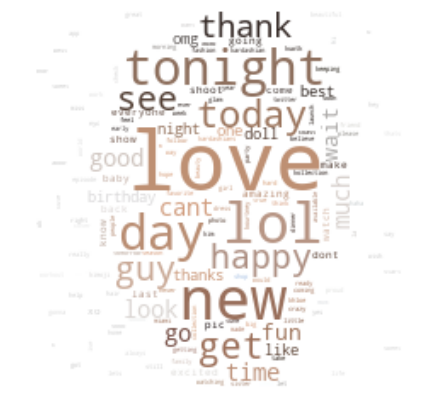

[('love', 3195),
 ('new', 1380),
 ('lol', 1261),
 ('tonight', 1085),
 ('day', 1084),
 ('today', 1062),
 ('get', 997),
 ('happy', 987),
 ('see', 947),
 ('guy', 943)]

In [211]:
# let's look at what a cryface kimoji shaped wordcloud would look like
kim_mask = np.array(Image.open("kimoji.png"))

# putting all 2012 tweets into one single string
onestring = " ".join(clouddict.values())
all_tweet_word_list = re.split('\s+', onestring)
all_tweet_word_list = [w.lower() for w in all_tweet_word_list]
c = Counter(all_tweet_word_list)


# Generate a word cloud image
mask = np.array(Image.open("kimoji.png"))
wordcloud_kimoji = WordCloud(background_color="white", mode="RGBA", 
                             max_words=2000, mask=mask).generate_from_frequencies(c)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[7,7])
plt.imshow(wordcloud_kimoji.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

plt.show()

#generate_from_frequencies(text)
c.most_common(10)

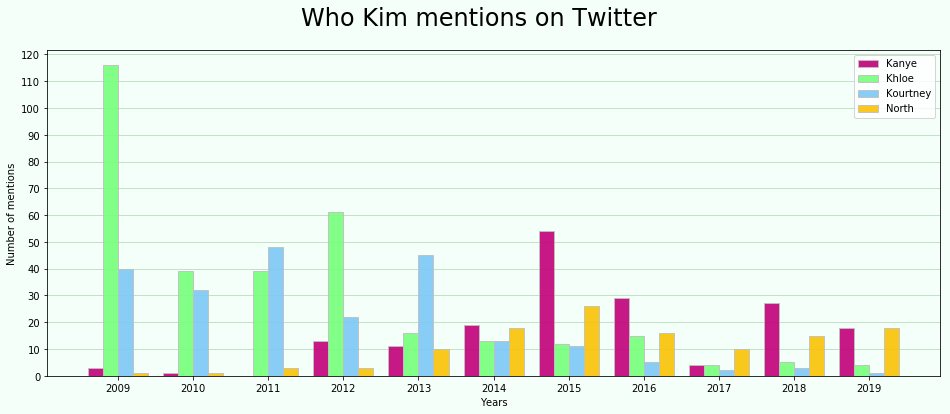

In [105]:
'''
apparently Kim is really thankful, has a big heart and also really wants people to watch KUWTK

'''

counterdict = {}
for key in clouddict.keys():
    counterdict[key] = Counter(clouddict[key].upper().split())

def wordcounter(wordstr):
    countlist = []
    for key in counterdict:
        wordnum = counterdict[key][wordstr.upper()]
        countlist.append(wordnum)
    return countlist


bg_c = "mintcream"
index = np.arange(len(years))
bar_width = 0.2
opacity = 0.9
barcolors = ['xkcd:magenta', 'xkcd:lightgreen', 'xkcd:lightblue', 'xkcd:goldenrod']
ec = "silver"

fig1 = plt.figure(figsize=(16, 6))
fig1.suptitle('Who Kim mentions on Twitter', size=24)
fig1.set_facecolor(bg_c)

ax1 = fig1.add_subplot(111)
ax1.set_facecolor(bg_c)

Kanye = ax1.bar(index, wordcounter("kanye"), width=bar_width, alpha=opacity, zorder=2,
                color=barcolors[0], ec=ec, label='Kanye')

Khloe = ax1.bar(index + bar_width, wordcounter("khloe"), width=bar_width, alpha=opacity, zorder=2,
               color=barcolors[1], ec=ec, label='Khloe')

Kourtney = ax1.bar(index + 2 * bar_width, wordcounter("kourtney"), width=bar_width, alpha=opacity, zorder=2,
                  color=barcolors[2], ec=ec, label='Kourtney')

North = ax1.bar(index + 3 * bar_width, wordcounter("north"), width=bar_width, alpha=opacity, zorder=2,
               color=barcolors[3], ec=ec, label='North')

plt.xticks(index + bar_width*1.5, years)
plt.grid(axis="y", c="forestgreen", zorder=2, alpha=.3)

ax1.set_xlabel('Years')
ax1.set_ylabel('Number of mentions')
ax1.set_yticks(np.arange(0,121,10))
ax1.legend()

plt.show()

In [243]:
row = clean.iloc[0]
type(row['tokenized_nonstop'])

list

In [245]:
import sqlite3
import json

conn = sqlite3.connect(':memory:')
c = conn.cursor()


c.execute("""CREATE TABLE kimtweets (
            date int,
            text text,
            cleaned text,
            tokenized_nonstop text,
            lemmatized text
)""")



with conn:
    for index in range(len(clean)):
        row = clean.iloc[index]
        tokenized = json.dumps(row["tokenized_nonstop"])
        lemmatized = json.dumps(row["lemmatized"])
        
        c.execute("INSERT INTO kimtweets VALUES (:date, :text, :cleaned, :tokenized_nonstop, :lemmatized)",
                  {"date": row["date"].strftime('%Y-%m-%d %H:%M:%S'),
                   "text": row["text"],
                   "cleaned": row["cleaned"],
                   "tokenized_nonstop": tokenized,
                   "lemmatized": lemmatized 
                  }
                 )

In [ ]:
c.execute("""SELECT * FROM kimtweets (
            first text,
            last text,
            pay integer
            )""")